In [11]:
import pandas as pd
import numpy as np
import cv2
import os
import random
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt

In [12]:
print("Number of CPUs in the system:", os.cpu_count())

Number of CPUs in the system: 12


## Loading dataset

In [23]:
meta = pd.read_csv('./meta.csv')
meta

,age,gender,path
0,68,male,imdb_crop/12/nm0864812_rm3917653760_1944-11-23...
1,46,female,imdb_crop/60/nm0000260_rm4261250304_1956-8-20_...
2,59,male,imdb_crop/65/nm0000165_rm4116248576_1954-3-1_2...
3,25,female,wiki_crop/53/2569353_1921-05-31_1947.jpg
4,30,female,imdb_crop/41/nm1443641_rm1540936192_1981-8-1_2...
...,...,...,...
224835,55,female,imdb_crop/00/nm0000700_rm3332553472_1955-5-16_...
224836,42,female,imdb_crop/32/nm1362432_rm3859195392_1971-0-0_2...
224837,37,male,imdb_crop/49/nm0241049_rm80250368_1972-11-14_2...
224838,26,male,imdb_crop/75/nm0010075_rm131114496_1978-3-1_20...


## Dropping gender column

In [24]:
meta = meta.drop(['gender'], axis=1)
meta

,age,path
0,68,imdb_crop/12/nm0864812_rm3917653760_1944-11-23...
1,46,imdb_crop/60/nm0000260_rm4261250304_1956-8-20_...
2,59,imdb_crop/65/nm0000165_rm4116248576_1954-3-1_2...
3,25,wiki_crop/53/2569353_1921-05-31_1947.jpg
4,30,imdb_crop/41/nm1443641_rm1540936192_1981-8-1_2...
...,...,...
224835,55,imdb_crop/00/nm0000700_rm3332553472_1955-5-16_...
224836,42,imdb_crop/32/nm1362432_rm3859195392_1971-0-0_2...
224837,37,imdb_crop/49/nm0241049_rm80250368_1972-11-14_2...
224838,26,imdb_crop/75/nm0010075_rm131114496_1978-3-1_20...


## Filtering dataset

In [25]:
meta = meta[meta['age'] >= 0]
meta = meta[meta['age'] <= 101]
meta

,age,path
0,68,imdb_crop/12/nm0864812_rm3917653760_1944-11-23...
1,46,imdb_crop/60/nm0000260_rm4261250304_1956-8-20_...
2,59,imdb_crop/65/nm0000165_rm4116248576_1954-3-1_2...
3,25,wiki_crop/53/2569353_1921-05-31_1947.jpg
4,30,imdb_crop/41/nm1443641_rm1540936192_1981-8-1_2...
...,...,...
224835,55,imdb_crop/00/nm0000700_rm3332553472_1955-5-16_...
224836,42,imdb_crop/32/nm1362432_rm3859195392_1971-0-0_2...
224837,37,imdb_crop/49/nm0241049_rm80250368_1972-11-14_2...
224838,26,imdb_crop/75/nm0010075_rm131114496_1978-3-1_20...


## Making the directory structure

In [13]:
modelFile = "../../Models/face-detection/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "../../Models/face-detection/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

In [14]:
output_dir = '../IMDB-WIKI/'

if not os.path.exists(output_dir):
   os.makedirs(output_dir)

In [8]:
def process_image(age_image_tuple):
    age, image = age_image_tuple
    img = cv2.imread(image, 1)
    h, w = img.shape[:2]
    min_dim = min(h, w)
    top, bottom = (h - min_dim) // 2, (h + min_dim) // 2
    left, right = (w - min_dim) // 2, (w + min_dim) // 2
    img_cropped = img[top:bottom, left:right]
    path = image
    path = path[path.rindex('/')+1:]
    path = '../IMDB-WIKI/' + str(age) + '_' + path
    cv2.imwrite(path, img_cropped)

In [10]:
meta = meta.values
meta

array([[68, 'imdb_crop/12/nm0864812_rm3917653760_1944-11-23_2013.jpg'],
       [46, 'imdb_crop/60/nm0000260_rm4261250304_1956-8-20_2003.jpg'],
       [59, 'imdb_crop/65/nm0000165_rm4116248576_1954-3-1_2014.jpg'],
       ...,
       [37, 'imdb_crop/49/nm0241049_rm80250368_1972-11-14_2010.jpg'],
       [26, 'imdb_crop/75/nm0010075_rm131114496_1978-3-1_2005.jpg'],
       [33, 'imdb_crop/51/nm0004851_rm1098946304_1974-4-28_2008.jpg']],
      dtype=object)

In [13]:
with ThreadPoolExecutor(max_workers=os.cpu_count()-2) as executor: # Adjust max_workers as needed
    executor.map(process_image, meta)

## Cutting images to 200x200

In [15]:
# Destination directory with 200x200 images
faces_dir = '../IMDB-WIKI-200/'
if not os.path.exists(faces_dir):
   os.makedirs(faces_dir)

In [16]:
# Destination directory with multi-face images
multi_dir = '../IMDB-WIKI-multi/'
if not os.path.exists(multi_dir):
   os.makedirs(multi_dir)

In [ ]:
def cut_images(path, newpath):
    if os.path.exists(newpath):
        return

    f = cv2.imread(path, 1)
    blob = cv2.dnn.blobFromImage(cv2.resize(f, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    face_count = 0
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            face_count += 1

    if face_count > 1:
        img_folder = os.path.join(multi_dir, os.path.splitext(os.path.basename(path))[0])
        os.makedirs(img_folder, exist_ok=True)

        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * np.array([f.shape[1], f.shape[0], f.shape[1], f.shape[0]])
                (x, y, x2, y2) = box.astype("int")
                r = (x2-x)-(y2-y)
                if(r>0):
                    m = (y+y2)//2
                    y = m - (x2-x)//2
                    y2 = m + (x2-x)//2
                elif(r<0):
                    m = (x+x2)//2
                    x= m - (y2-y)//2
                    x2 = m + (y2-y)//2
                if(x<0 or y<0):
                    continue
                extracted_face = f[y:y2, x:x2]
                height, width, channels = extracted_face.shape
                if(max(width, height)<200):
                    continue
                extracted_face = cv2.resize(extracted_face, (200,200))
                cv2.imwrite(os.path.join(img_folder, f'face_{i}.jpg'), extracted_face)
    else:
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.5:
                box = detections[0, 0, i, 3:7] * \
                    np.array([f.shape[1], f.shape[0], f.shape[1], f.shape[0]])
                (x, y, x2, y2) = box.astype("int")
                r = (x2-x)-(y2-y)
                if(r > 0):
                    m = (y+y2)//2
                    y = m - (x2-x)//2
                    y2 = m + (x2-x)//2
                elif(r < 0):
                    m = (x+x2)//2
                    x = m - (y2-y)//2
                    x2 = m + (y2-y)//2
                if(x < 0 or y < 0):
                    continue
                extracted_face = f[y:y2, x:x2]
                height, width, channels = extracted_face.shape
                if(max(width, height) < 200):
                    continue
                extracted_face = cv2.resize(extracted_face, (200, 200))
                cv2.imwrite(newpath, extracted_face)
[cut_images(os.path.join(output_dir, filename), os.path.join(faces_dir, filename)) for filename in os.listdir(output_dir)]

## Displaying random image from source dataset

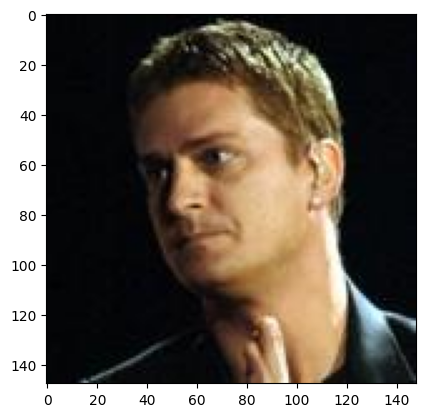

In [19]:
image_filenames = os.listdir(output_dir)
random_filename = random.choice(image_filenames)
full_image_path = os.path.join(output_dir, random_filename)
image = cv2.imread(full_image_path)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image)
plt.show()

The extracted face image size is: width=200px, height=200px, channels=3
Max = 200


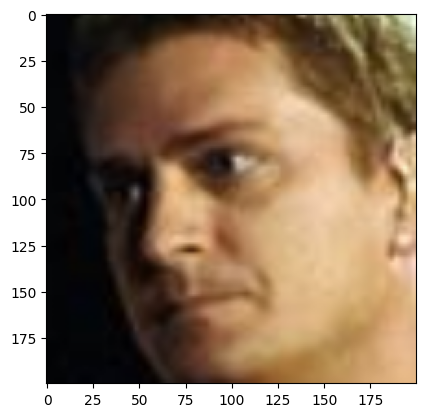

In [20]:
f = cv2.imread(full_image_path, 1)
blob = cv2.dnn.blobFromImage(cv2.resize(f, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
net.setInput(blob)
detections = net.forward()
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([f.shape[1], f.shape[0], f.shape[1], f.shape[0]])
        (x, y, x2, y2) = box.astype("int")
        r = (x2-x)-(y2-y)
        if(r > 0):
            m = (y+y2)//2
            y = m - (x2-x)//2
            y2 = m + (x2-x)//2
        elif(r < 0):
            m = (x+x2)//2
            x = m - (y2-y)//2
            x2 = m + (y2-y)//2
        if(x < 0 or y < 0):
            continue
        extracted_face = f[y:y2, x:x2]
        extracted_face = cv2.resize(extracted_face, (200, 200))
        height, width, channels = extracted_face.shape
        print(f'The extracted face image size is: width={width}px, height={height}px, channels={channels}')
        print(f'Max = {max(width,height)}')
        plt.imshow(cv2.cvtColor(extracted_face, cv2.COLOR_BGR2RGB))
        plt.show()

In [ ]:
cv2.destroyAllWindows()